<a href="https://colab.research.google.com/github/AnuruddhaPaul/sft_qwen2.5vl_7b/blob/main/sft_qwen2_5vl_7b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to fine-tune a VLM on `reasoning-10k-v2`

1. To view our dataset on Hugging Face 🤗, please follow this link: https://huggingface.co/datasets/ArkaMukherjee/mmCultural

2. Dataset building logic notebook: https://colab.research.google.com/drive/1UwKu_8QOUlSusHvyXvtn-MN78LJ2wJhn?usp=sharing

3. Don't forget to star our GitHub repo: https://github.com/ArkaMukherjee0/reasoning-10k-v2

We will perform supervised fine-tuning (SFT) on the 4-bit quantization of Qwen 2.5 VL 7B with `reasoning-10k-v2`. Code to generate the dataset can be found in this Colab notebook:

Note that SFTing Qwen 2.5 VL 7B requires at least 24 GB of VRAM (RTX 4090 and above). Our code was ran locally with an RTX 5090 and could lead to OOM errors on Colab's free T4 GPU. While we provide an optimized version that's Colab-friendly, we recommend at least an A100 40 GB for smooth working of the following code.

A high RAM variant iS also needed to load the dataset.

## Loading the Qwen 2.5 VL 7B model

We will use Qwen 2.5 VL 7B with 4-bit quantization from the Unsloth library. This provides training-ready optimizations that dramatically cuts VRAM requirements.

In [ ]:
!pip install unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct",
    #load_in_4bit = False,
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    # load_in_4bit = False,
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
    # cache_dir="D:/models"
)

C:\Users\CoolA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\triton\windows_utils.py:441: UserWarning: Failed to find CUDA.
  warnings.warn("Failed to find CUDA.")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W0930 11:46:41.606000 25300 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Switching to PyTorch attention since your Xformers is broken.

Unsloth: Xformers does not work in RTX 50X, Blackwell GPUs as of yet. Please build from source via
```
pip install ninja
pip install -v --no-build-isolation -U git+https://github.com/facebookresearch/xformers.git@main#egg=xformers
```

🦥 Unsloth Zoo will now patch everything to make training faster!


C:\Users\CoolA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\unsloth_zoo\gradient_checkpointing.py:341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.6: Fast Qwen2_5_Vl patching. Transformers: 4.55.4.
   \\   /|    NVIDIA GeForce RTX 5090. Num GPUs = 1. Max memory: 31.842 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 12.0. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [ ]:
import torch

# Windows trick to avoid PyTorch errors. Can be ignored if ran on Google Colab.

torch._dynamo.config.suppress_errors = True
torch._inductor.config.triton.cudagraphs = False

# completely disable TorchInductor
torch._dynamo.config.disable = True

## Prepping the dataset

Let's load the `reasoning-10k-v2` dataset from Hugging Face (link: https://huggingface.co/datasets/ArkaMukherjee/reasoning-10k-v2). Note: this code fails on the free T4 version of Colab with 12.7 GB RAM.

In [ ]:
import json
import pandas as pd
from PIL import Image
import os
from typing import List, Dict, Any, Optional
import base64
from io import BytesIO
import traceback
from datasets import load_dataset

def load_unified_dataset(dataset_name: str = "ArkaMukherjee/reasoning-10k-v2", limit: int = None) -> List[Dict]:
    """Load unified dataset from Hugging Face with optional limit for testing"""
    print(f"Loading dataset from Hugging Face: {dataset_name}...")

    try:
        dataset = load_dataset(dataset_name, split="train")
        data = [item for item in dataset]

        if limit:
            data = data[:limit]

        print(f"Successfully loaded {len(data)} dataset entries")
        return data

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return []

def decode_base64_image(base64_string: str) -> Optional[Image.Image]:
    """Decode base64 image string to PIL Image"""
    if not base64_string:
        return None

    try:
        if base64_string.startswith('data:image'):
            base64_string = base64_string.split(',', 1)[1]

        image_data = base64.b64decode(base64_string)
        img = Image.open(BytesIO(image_data))
        if img.mode not in ('RGB', 'L'):
            img = img.convert('RGB')

        return img

    except Exception as e:
        print(f"Failed to decode image: {e}")
        return None

def convert_to_conversation(item: Dict, item_idx: int = None) -> Optional[Dict]:
    """Convert a dataset item to the conversation format for fine-tuning"""

    try:
        # Decode the image from base64
        image = None
        if item.get('image'):
            image = decode_base64_image(item['image'])

        # Extract the question, solution, and answer
        question = str(item.get('question', ''))
        solution = str(item.get('solution', ''))
        answer = str(item.get('answer', ''))

        user_content = [{"type": "text", "text": question}]

        if image is not None:
            user_content.append({"type": "image", "image": image})

        conversation = [
            {
                "role": "user",
                "content": user_content,
            },
            {"role": "assistant", "content": [{"type": "text", "text": solution}]},
        ]

        return {
            "messages": conversation,
            "metadata": {
                "dataset_name": item.get('dataset_name', 'unknown'),
                "uid": item.get('uid', f'item_{item_idx}'),
                "answer": answer,
                "has_image": image is not None,
                "original_metadata": item.get('metadata', {})
            }
        }

    except Exception as e:
        print(f"Error converting item {item_idx}: {e}")
        return None

def prepare_dataset(dataset: List[Dict], limit: int = None,
                   start_idx: int = 0, save_interval: int = 1000,
                   checkpoint_path: str = None) -> tuple[List[Dict], List[Dict]]:
    """Prepare the complete dataset for fine-tuning with checkpointing"""
    print("Converting dataset to conversation format...")

    converted_dataset = []
    failed_conversions = []

    if limit:
        dataset = dataset[:limit]

    # Start from specific index if resuming
    if start_idx > 0 and checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Resuming from index {start_idx}...")
        print(f"Loading checkpoint from {checkpoint_path}...")
        with open(checkpoint_path, 'r', encoding='utf-8') as f:
            for line in f:
                converted_dataset.append(json.loads(line))
        print(f"Loaded {len(converted_dataset)} samples from checkpoint")

    total = len(dataset)

    for idx, item in enumerate(dataset):
        if idx < start_idx:
            continue

        try:
            if (idx + 1) % 100 == 0:
                print(f"Processed {idx + 1}/{total} samples... (Success: {len(converted_dataset)}, Failed: {len(failed_conversions)})")

            # Convert to conversation format
            conversation = convert_to_conversation(item, item_idx=idx)

            if conversation is not None:
                converted_dataset.append(conversation)
            else:
                failed_conversions.append({
                    'index': idx,
                    'uid': item.get('uid', f'item_{idx}'),
                    'dataset_name': item.get('dataset_name', 'unknown')
                })

            if checkpoint_path and (idx + 1) % save_interval == 0:
                print(f"Saving checkpoint at {idx + 1} samples...")
                save_checkpoint(converted_dataset, checkpoint_path)

        except KeyboardInterrupt:
            print(f"\nInterrupted at index {idx}. Saving checkpoint...")
            if checkpoint_path:
                save_checkpoint(converted_dataset, checkpoint_path)
            raise

        except Exception as e:
            print(f"Unexpected error at index {idx}: {e}")
            failed_conversions.append({
                'index': idx,
                'uid': item.get('uid', f'item_{idx}'),
                'error': str(e)
            })
            continue

    print(f"\nSuccessfully converted {len(converted_dataset)} samples")
    print(f"Failed conversions: {len(failed_conversions)}")

    return converted_dataset, failed_conversions

def save_checkpoint(dataset: List[Dict], checkpoint_path: str):
    """Save checkpoint of converted dataset"""
    with open(checkpoint_path, 'w', encoding='utf-8') as f:
        for sample in dataset:
            # not using PIL Image objects
            serializable_sample = {
                "messages": [
                    {
                        "role": msg["role"],
                        "content": [
                            {"type": item["type"], "text": item["text"]} if item["type"] == "text"
                            else {"type": "image", "image": "<IMAGE_PLACEHOLDER>"}
                            for item in msg["content"]
                        ]
                    } for msg in sample["messages"]
                ],
                "metadata": sample["metadata"]
            }
            f.write(json.dumps(serializable_sample, ensure_ascii=False) + '\n')

def save_dataset(dataset: List[Dict], output_path: str):
    """Save the prepared dataset"""
    print(f"Saving dataset to {output_path}...")

    with open(output_path, 'w', encoding='utf-8') as f:
        for sample in dataset:
            # let's not use PIL Image objects
            serializable_sample = {
                "messages": [
                    {
                        "role": msg["role"],
                        "content": [
                            {"type": item["type"], "text": item["text"]} if item["type"] == "text"
                            else {"type": "image", "image": "<IMAGE_PLACEHOLDER>"}
                            for item in msg["content"]
                        ]
                    } for msg in sample["messages"]
                ],
                "metadata": sample["metadata"]
            }
            f.write(json.dumps(serializable_sample, ensure_ascii=False) + '\n')

    print(f"Dataset saved successfully!")

def analyze_dataset(dataset: List[Dict]):
    """Analyze the loaded dataset and print statistics"""
    print("\n" + "="*50)
    print("DATASET ANALYSIS")
    print("="*50)

    print(f"Total samples: {len(dataset)}")

    # Count by dataset type
    dataset_counts = {}
    image_counts = {'with_image': 0, 'without_image': 0}

    for item in dataset:
        dataset_name = item.get('dataset_name', 'unknown')
        dataset_counts[dataset_name] = dataset_counts.get(dataset_name, 0) + 1

        if item.get('image'):
            image_counts['with_image'] += 1
        else:
            image_counts['without_image'] += 1

    print("\nDataset composition:")
    for dataset_name, count in sorted(dataset_counts.items()):
        percentage = (count / len(dataset)) * 100
        print(f"  {dataset_name}: {count:,} samples ({percentage:.1f}%)")

    print(f"\nImage statistics:")
    print(f"  With images: {image_counts['with_image']:,}")
    print(f"  Without images: {image_counts['without_image']:,}")

dataset = load_unified_dataset("ArkaMukherjee/reasoning-10k-v2")

if not dataset:
    print("Failed to load dataset. Exiting.")
    exit(0)
analyze_dataset(dataset)


print(f"\nPreparing dataset for fine-tuning...")

checkpoint_path = "checkpoint_unified_dataset.jsonl"
start_idx = 0  # changeable to resume from crashes

try:
    converted_dataset, failed_conversions = prepare_dataset(
        dataset,
        start_idx=start_idx,
        save_interval=1000,
        checkpoint_path=checkpoint_path
    )

    if converted_dataset:
        print("\n" + "="*50)
        print("SAMPLE CONVERSATION:")
        print("="*50)
        sample = converted_dataset[0]
        print(f"UID: {sample['metadata']['uid']}")
        print(f"Dataset: {sample['metadata']['dataset_name']}")
        print(f"Answer: {sample['metadata']['answer']}")
        print(f"Has image: {sample['metadata']['has_image']}")
        print("\nUser message (first 200 chars):")
        print(f"Text: {sample['messages'][0]['content'][0]['text'][:200]}...")
        if sample['metadata']['has_image']:
            print(f"Image: {type(sample['messages'][0]['content'][1]['image'])}")
        print("\nAssistant response (first 300 chars):")
        print(f"Text: {sample['messages'][1]['content'][0]['text'][:300]}...")

    # output_path = "prepared_unified_10k_dataset.jsonl"
    # save_dataset(converted_dataset, output_path)

    print(f"\nDataset preparation complete! Total samples: {len(converted_dataset)}")
    print(f"Saved to: {output_path}")

    final_stats = {}
    for item in converted_dataset:
        dataset_name = item['metadata']['dataset_name']
        final_stats[dataset_name] = final_stats.get(dataset_name, 0) + 1

    print(f"\nFinal dataset composition:")
    for dataset_name, count in sorted(final_stats.items()):
        percentage = (count / len(converted_dataset)) * 100
        print(f"  {dataset_name}: {count:,} samples ({percentage:.1f}%)")

except KeyboardInterrupt:
    print("\nProcess interrupted by user")
except Exception as e:
    print(f"Fatal error: {e}")
    traceback.print_exc()

Loading dataset from Hugging Face: ArkaMukherjee/reasoning-10k-v2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/394 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/342M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/343M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Sample inference

Let's look at a sample inference to get an idea of how the model performs.

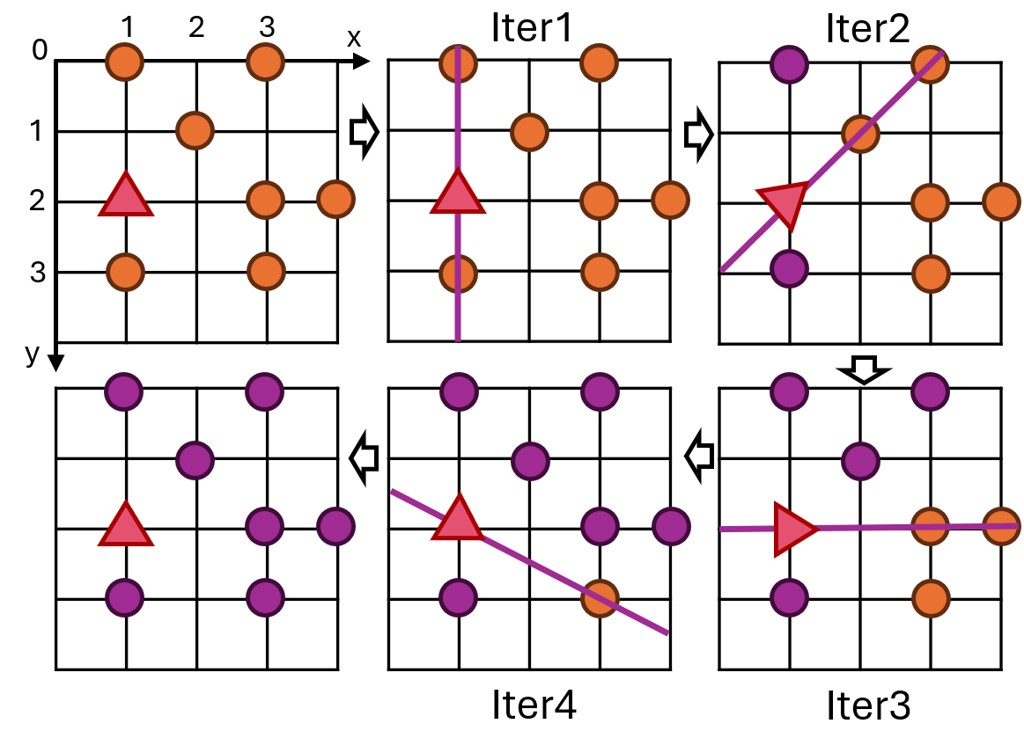

torch.Size([3848, 1176]) torch.float32
```python
import math

def find_slope_intercept(x1: int, x2: int, y1: int, y2: int) -> dict:
    """Find slope and intercept of a line given two points."""
    dx = x2 - x1
    dy = y2 - y1
    return {
        'slope': dy / dx,
        'intercept': y1 - dx * slope if dx != 0 else float('inf')
    }

def check_infinite_lines(point_x, point_y, slope):
    """Check for infinite slope (vertical lines)."""
    if abs(slope) >= 10 ** 35:
        return True
    else:
        return False

def line_to_point_distance(x1, y1, x2, y2):
    """Calculate the distance from the point to the line formed by the line."""
    return abs((y2 - y1) * x1 + (x1 - x2) * y1 - x1 * y2 + x2 * y1) / math.sqrt(
        pow(y2 - y1, 2) + pow(x1 - x2, 2))

def is_point_between_points(point_x, point_y, x1, y1, x2, y2):
    """Determine if the point is between two points."""
    dist_1 = abs(point_x - x1)**2 + abs(point_y - y1)**2
    dist_2 = abs(point_x - x2)**2 + abs(point_y

In [ ]:
def perform_sample_inference(model, tokenizer, dataset, sample_idx=0):
    from transformers import TextStreamer
    from IPython.display import display  # for showing images in Jupyter

    # Enable inference mode (only for Unsloth)
    FastVisionModel.for_inference(model)  # Uncomment when using unsloth

    sample = dataset[sample_idx]
    image = sample['messages'][0]['content'][1]['image']  # PIL Image
    instruction_text = sample['messages'][0]['content'][0]['text']

    # Load image if it's a path string (in case image wasn't loaded properly)
    if isinstance(image, str) and image.startswith('<PIL_Image_from_path:'):
        # Extract path and load image
        image_path = image.split('<PIL_Image_from_path: ')[1].rstrip('>')
        from PIL import Image
        image = Image.open(image_path)

    # 👀 Display the image
    display(image)

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction_text}
        ]}
    ]

    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    print(inputs["pixel_values"].shape, inputs["pixel_values"].dtype)
    _ = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=1280,
        use_cache=True,
        temperature=1.5,
        min_p=0.1
    )

perform_sample_inference(model, tokenizer, converted_dataset, 0)

## Evaluating VMCBench_DEV before fine-tuning

As a baseline, let's evaluate VMCBench's DEV split before SFTing with our dataset.

In [ ]:
import re
from datasets import load_dataset
from PIL import Image
import io
import base64
from typing import Optional, Dict, Any, List
import numpy as np
import torch
from collections import defaultdict

def extract_latex_answer(text: str) -> Optional[str]:
    """Extract answer from \\boxed{} latex format"""
    pattern = r'\\boxed\{([^}]*)\}'
    matches = re.findall(pattern, text)
    if matches:
        # Return the last match and clean it
        answer = matches[-1].strip()
        # Extract just the letter if it's in the format
        letter_match = re.match(r'^([A-D])', answer, re.IGNORECASE)
        if letter_match:
            return letter_match.group(1).upper()
        return answer.upper()
    return None

def extract_answer_fallback(text: str) -> Optional[str]:
    """Fallback method to extract answer if \\boxed{} format not found"""
    # Look for common patterns like "The answer is A" or just "A" at the end
    patterns = [
        r'(?:answer is|answer:|final answer is|final answer:)\s*([A-D])',
        r'\b([A-D])\s*(?:is correct|is the answer)',
        r'^([A-D])$',  # Just the letter alone
        r'(?:^|\n)([A-D])(?:\.|,|\s|$)'  # Letter at start of line or standalone
    ]

    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE)
        if match:
            return match.group(1).upper()

    # Last resort: check if any single letter A-D appears in the last line
    lines = text.strip().split('\n')
    if lines:
        last_line = lines[-1].strip()
        for letter in ['A', 'B', 'C', 'D']:
            if letter in last_line.upper():
                return letter

    return None

def format_vmcbench_question(question: str, A: str, B: str, C: str, D: str) -> str:
    """Format VMC-Bench question with options"""
    formatted = f"{question}\nA. {A}\nB. {B}\nC. {C}\nD. {D}\n\nProvide your answer in the format \\boxed{{answer}} (e.g., \\boxed{{A}} or \\boxed{{B}})."
    return formatted

def run_inference_vmcbench(model, tokenizer, image, question_text: str) -> str:
    """Run inference on a VMC-Bench sample"""
    # Enable inference mode
    FastVisionModel.for_inference(model)

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": question_text}
        ]}
    ]

    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=1280,
            use_cache=True,
            temperature=0.1,  # Lower temperature for more deterministic answers
            min_p=0.1,
            do_sample=True
        )

    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the generated part (after the input)
    input_length = len(tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True))
    generated_text = response[input_length:].strip()

    return generated_text

def compare_vmcbench_answers(predicted: str, ground_truth: str) -> bool:
    """Compare predicted answer with ground truth for VMC-Bench"""
    if not predicted:
        return False

    # Both should be single letters A, B, C, or D
    predicted = predicted.strip().upper()
    ground_truth = ground_truth.strip().upper()

    return predicted == ground_truth

def evaluate_vmcbench_dev(model, tokenizer, max_samples: Optional[int] = None,
                          verbose: bool = True) -> Dict[str, Any]:
    """
    Evaluate model on VMC-Bench dev split

    Args:
        model: The vision-language model
        tokenizer: The tokenizer
        max_samples: Maximum number of samples to evaluate (None for all)
        verbose: Whether to print detailed results

    Returns:
        Dictionary with evaluation results
    """

    # Load the dataset
    print("Loading VMC-Bench dev split...")
    dataset = load_dataset("suyc21/VMCBench", split="dev")

    if max_samples:
        dataset = dataset.select(range(min(max_samples, len(dataset))))

    print(f"Evaluating on {len(dataset)} samples...")

    correct = 0
    total = 0
    results = []

    # Track performance by category
    category_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

    for i, sample in enumerate(dataset):
        try:
            # Extract sample data
            index = sample.get('index', i)
            question = sample['question']
            option_A = sample['A']
            option_B = sample['B']
            option_C = sample['C']
            option_D = sample['D']
            ground_truth = sample['answer']  # Should be A, B, C, or D
            category = sample.get('category', 'unknown')
            image = sample['image']  # PIL Image

            # Convert image if needed
            if isinstance(image, str):
                # If image is base64 encoded
                image_data = base64.b64decode(image)
                image = Image.open(io.BytesIO(image_data))
            elif not isinstance(image, Image.Image):
                # Convert to PIL Image if not already
                image = Image.fromarray(np.array(image))

            # Format the question with options
            formatted_question = format_vmcbench_question(question, option_A, option_B, option_C, option_D)

            # Run inference
            generated_text = run_inference_vmcbench(model, tokenizer, image, formatted_question)

            # Extract answer from latex format
            predicted_answer = extract_latex_answer(generated_text)

            # If extraction failed, try fallback methods
            if not predicted_answer or predicted_answer not in ['A', 'B', 'C', 'D']:
                predicted_answer = extract_answer_fallback(generated_text)

            # Ensure we have a valid answer
            if not predicted_answer:
                predicted_answer = "INVALID"

            # Compare with ground truth
            is_correct = compare_vmcbench_answers(predicted_answer, ground_truth)

            if is_correct:
                correct += 1
                category_stats[category]['correct'] += 1

            total += 1
            category_stats[category]['total'] += 1

            # Store result
            result = {
                'index': index,
                'question': question,
                'options': {
                    'A': option_A,
                    'B': option_B,
                    'C': option_C,
                    'D': option_D
                },
                'category': category,
                'ground_truth': ground_truth,
                'predicted': predicted_answer,
                'generated_text': generated_text,
                'correct': is_correct
            }
            results.append(result)

            if verbose and (i + 1) % 10 == 0:
                current_acc = correct / total
                print(f"Progress: {i + 1}/{len(dataset)}, Accuracy so far: {current_acc:.3f}")

            if verbose and i < 5:  # Show first few examples
                print(f"\n--- Example {i + 1} ---")
                print(f"Category: {category}")
                print(f"Question: {question}")
                print(f"A. {option_A}")
                print(f"B. {option_B}")
                print(f"C. {option_C}")
                print(f"D. {option_D}")
                print(f"Ground Truth: {ground_truth}")
                print(f"Predicted: {predicted_answer}")
                print(f"Correct: {is_correct}")
                print(f"Generated (first 200 chars): {generated_text[:200]}..." if len(generated_text) > 200 else f"Generated: {generated_text}")

        except Exception as e:
            print(f"Error processing sample {i} (index {sample.get('index', i)}): {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    # Calculate final metrics
    accuracy = correct / total if total > 0 else 0

    # Calculate accuracy by category
    category_accuracy = {}
    for cat, stats in category_stats.items():
        if stats['total'] > 0:
            category_accuracy[cat] = {
                'accuracy': stats['correct'] / stats['total'],
                'correct': stats['correct'],
                'total': stats['total']
            }

    # Count invalid predictions
    invalid_predictions = sum(1 for r in results if r['predicted'] == "INVALID")

    evaluation_results = {
        'overall_accuracy': accuracy,
        'total_samples': total,
        'correct_samples': correct,
        'invalid_predictions': invalid_predictions,
        'accuracy_by_category': category_accuracy,
        'detailed_results': results
    }

    # Print summary
    print(f"\n{'='*60}")
    print(f"VMC-BENCH DEV SPLIT EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.3f} ({correct}/{total})")
    print(f"Invalid Predictions: {invalid_predictions}/{total} ({invalid_predictions/total*100:.1f}%)")

    if category_accuracy:
        print(f"\nAccuracy by Category:")
        # Sort by category name for consistent display
        for cat in sorted(category_accuracy.keys()):
            stats = category_accuracy[cat]
            print(f"  {cat}: {stats['accuracy']:.3f} ({stats['correct']}/{stats['total']})")

    # Show some incorrect predictions for debugging
    incorrect_results = [r for r in results if not r['correct']]
    if incorrect_results and verbose:
        print(f"\nSample Incorrect Predictions (first 3):")
        for i, r in enumerate(incorrect_results[:3]):
            print(f"\n  {i+1}. Category: {r['category']}")
            print(f"     Question: {r['question'][:100]}...")
            print(f"     Ground Truth: {r['ground_truth']}")
            print(f"     Predicted: {r['predicted']}")
            print(f"     Generated: {r['generated_text'][:150]}...")

    return evaluation_results

# Run evaluation on first 50 samples
results = evaluate_vmcbench_dev(model, tokenizer, max_samples=1000, verbose=True)

# Run full evaluation
results = evaluate_vmcbench_dev(model, tokenizer, verbose=True)

# Save detailed results if needed
# import json
# with open('vmcbench_dev_results.json', 'w') as f:
#     json.dump(results, f, indent=2, default=str)

# print(f"\nResults saved to vmcbench_dev_results.json")

Loading VMC-Bench dev split...


README.md: 0.00B [00:00, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/520M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8018 [00:00<?, ? examples/s]

Evaluating on 1000 samples...

--- Example 1 ---
Category: MMMU
Question: Write the signal f(t) shown in <image 1> using the step functions.
A. 5t^2 [u(t) - u(t - 2)] + 20[u(t - 2) - u(t - 5)] + 15(t - 7)[u(t - 5) - u(t - 7)]
B. 5t^2 [u(t) - u(t - 2)] + 15[u(t - 2) - u(t - 5)] + 15(t - 7)[u(t - 5) - u(t - 7)]
C. 5t^2 [u(t) - u(t - 2)] + 20[u(t - 2) - u(t - 5)] + 10(t - 7)[u(t - 5) - u(t - 7)]
D. 5t [u(t) - u(t - 2)] + 20[u(t - 2) - u(t - 5)] + 15(t - 7)[u(t - 5) - u(t - 7)]
Ground Truth: A
Predicted: C
Correct: False
Generated (first 200 chars): To determine the correct expression for the signal \( f(t) \) using step functions, we need to break down the function into segments and express each segment using the Heaviside step function \( u(t) ...

--- Example 2 ---
Category: MMMU
Question: <image 1> deals with the study of political conduct within a ____ frame of reference.
A. Cultural
B. Economic
C. Sociological
D. Psychological
Ground Truth: C
Predicted: C
Correct: True
Generated: \bo

KeyboardInterrupt: 

## Training - trlSFT

Let's train our model!

In [ ]:
len(converted_dataset)

10000

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

# if isinstance(model, torch._dynamo.eval_frame.OptimizedModule):
#     model = model._orig_mod

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 1,
        warmup_ratio = 0.03,
        # max_steps = 375,
        num_train_epochs = 1, # Set this instead of max_steps for full training runs

        max_grad_norm = 2.0,
        learning_rate = 2e-5,

        logging_steps = 50,
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        # output_dir = "outputs",
        report_to = "none",     # For Weights and Biases
        save_safetensors = False,
        save_strategy = "no",

        # dataloader_num_workers = 4,
        # dataloader_prefetch_factor = 2,

        gradient_checkpointing_kwargs = {"use_reentrant": False},

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 16384,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 5090. Max memory = 31.842 GB.
7.432 GB of memory reserved.


#### Memory diag

In [ ]:
import psutil, os
p = psutil.Process(os.getpid())
print("Memory (rss, vms) MB:", p.memory_info().rss/1024**2, p.memory_info().vms/1024**2)

Memory (rss, vms) MB: 4252.87109375 17487.546875


### Training

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,000 | Num Epochs = 1 | Total steps = 10,000
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 51,521,536 of 8,343,688,192 (0.62% trained)


Step,Training Loss
50,1.875200
100,1.557100
150,1.276000
200,1.209200
250,0.982700
300,0.921200
350,0.838500
400,0.802300
450,0.701800
500,0.653900


#### Memory diag

In [ ]:
import psutil, os
p = psutil.Process(os.getpid())
print("Memory (rss, vms) MB:", p.memory_info().rss/1024**2, p.memory_info().vms/1024**2)

## Inference after training

Let's check how model behavior changed after training

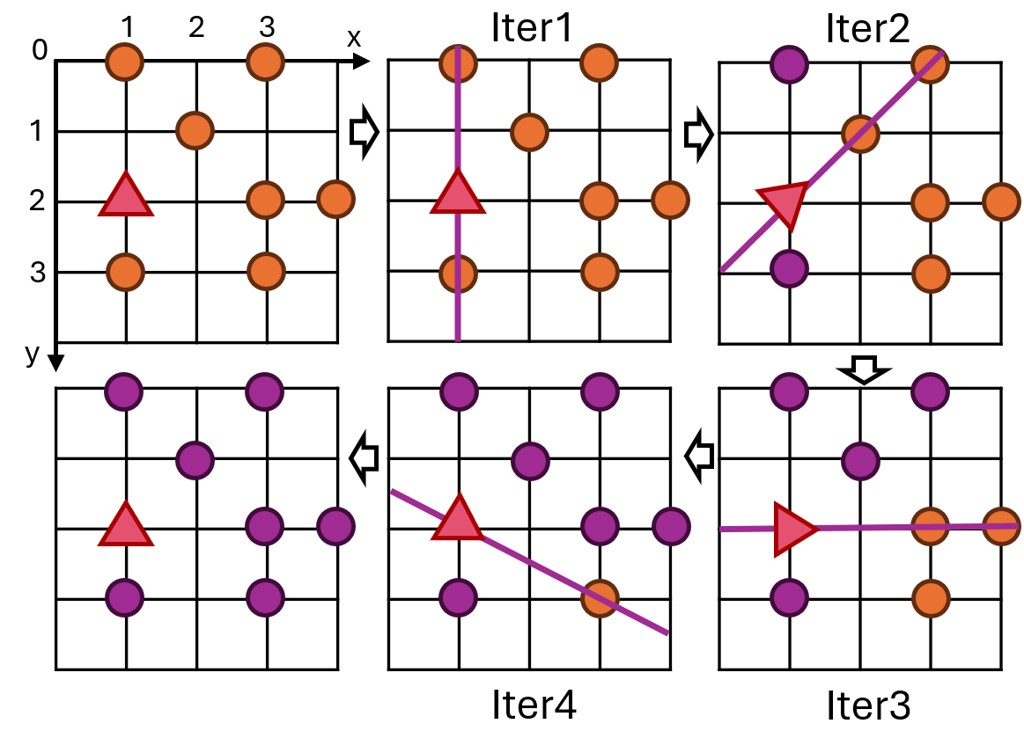

torch.Size([3848, 1176]) torch.float32
```python
import math

# Define utility functions for checking angles between vectors and handling geometric operations.

def check_angle(point: tuple):
    if point[0] >= 3 or point[1] == 3:
        return 180 - math.asin(abs(point[0]/point[1]) * 180 / math.pi)
    elif point[0] == 4 and point[1] > 2:
        return 360 + math.asin(abs(point[0]/point[1]) * 180 / math.pi)
    else:
        return round(math.asin(abs(point[0]/point[1]) * 180 / math.pi), 3)

def line(x0: int, y0: int, x1: int, y1: int, x2: int) -> None:
    x = x2 - x1
    y = y2 - y0

    a = -(y2 - y0)/(x2 - x0)
    b = y2/(x2 - x0)
    c = x2*y0 - x2*y

    dx = abs(a)
    dy = abs(b)

    dx_2 = dx * dx
    dy_2 = dy * dy
    num = min(dy_2, dx_2)
    denominator = num + dy_2 + dx_2 + dx_2 * dx_2 / dy_2
    if x < 0:
        if a < 0:
            angle = check_angle((abs(y2), -x2))
        elif y > 0:
            angle = 180 + check_angle((x2, abs(y2)))
        else:
           

In [ ]:
def perform_sample_inference(model, tokenizer, dataset, sample_idx=0):
    from transformers import TextStreamer
    from IPython.display import display  # for showing images in Jupyter

    # Enable inference mode (only for Unsloth)
    FastVisionModel.for_inference(model)  # Uncomment when using unsloth

    sample = dataset[sample_idx]
    image = sample['messages'][0]['content'][1]['image']  # PIL Image
    instruction_text = sample['messages'][0]['content'][0]['text']

    # Load image if it's a path string (in case image wasn't loaded properly)
    if isinstance(image, str) and image.startswith('<PIL_Image_from_path:'):
        # Extract path and load image
        image_path = image.split('<PIL_Image_from_path: ')[1].rstrip('>')
        from PIL import Image
        image = Image.open(image_path)

    # 👀 Display the image
    display(image)

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction_text}
        ]}
    ]

    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    print(inputs["pixel_values"].shape, inputs["pixel_values"].dtype)
    _ = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=1280,
        use_cache=True,
        temperature=1.5,
        min_p=0.1
    )

perform_sample_inference(model, tokenizer, converted_dataset, 0)

## More sample inference

Let's test more samples from the dataset.

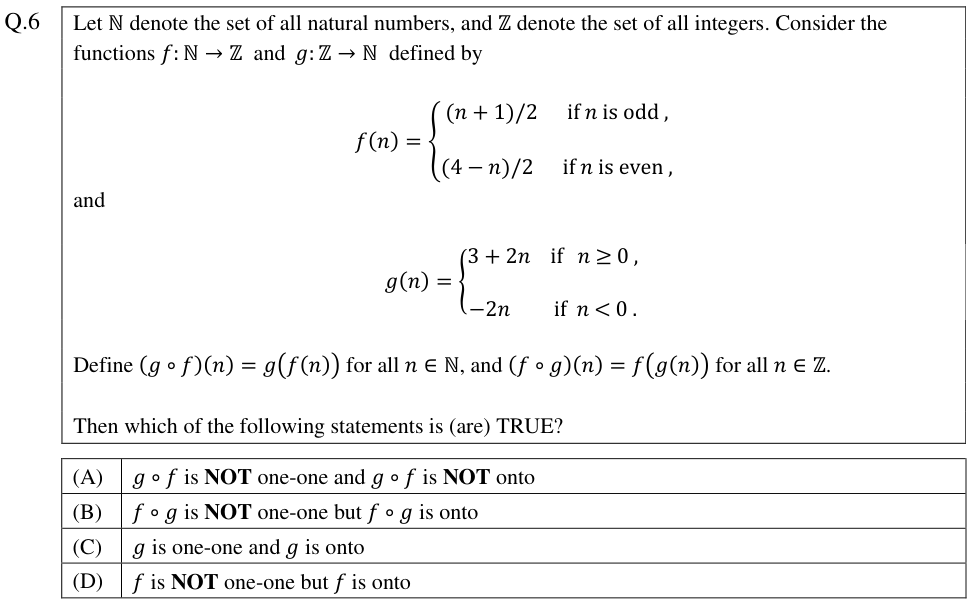

torch.Size([3080, 1176]) torch.float32
Here is the detailed solution with the rationale:

We must calculate functions $g\circ f$ and $f\circ g$. By the problem statement, these compositions map natural numbers to integers.

1. First we look at option (A). For this, we check whether both $g\circ f$ is one-to-one and onto. For a function to be onto, its image set has to be the target domain of that particular function, which would be all integers $\mathbb Z$. However, there aren't enough natural numbers (domain) to map into negative numbers, so the image can only contain non-negative even and odd numbers.

   We see that $g(f(n))=g((n+1)/2)\quad if n \ is \ odd$, so we have:
   $$g((n+1)/2)= \left\{\begin{array}{ccc}
            3 & if  \\& n&odd&\\
         0 & if &n &even\end{array}\right. $$
   Now observe that this sequence goes:
    \begin{array}{|c||c|}
      \hline
        n & g((n+1)/2) \\
        \hline 
       \quad odd\quad n & \quad even \quad m: m=(n+1)/2 \\ 
        1 & 0 \

In [ ]:
def perform_sample_inference_manual(model, tokenizer):
    from transformers import TextStreamer
    from IPython.display import display  # for showing images in Jupyter
    from PIL import Image

    # Enable inference mode (only for Unsloth)
    FastVisionModel.for_inference(model)  # Uncomment when using unsloth

    image_path = r"C:\Multilingual Dataset\final_dataset\images\2025\P1\English\Mathematics\2025_P1_English_Mathematics_MCQ-Multiple_q2_MCQ-Multiple_page4.png"
    image = Image.open(image_path)
    instruction_text = '''Solve this multi-correct math question. Come up with a detailed analysis and mark your answer in latex as \\boxed{final_answer} (e.g., \\boxed{AB} or \\boxed{ABC})'''

    # 👀 Display the image
    display(image)

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction_text}
        ]}
    ]

    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    print(inputs["pixel_values"].shape, inputs["pixel_values"].dtype)
    _ = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=1280,
        use_cache=True,
        temperature=1.5,
        min_p=0.1
    )

perform_sample_inference_manual(model, tokenizer)

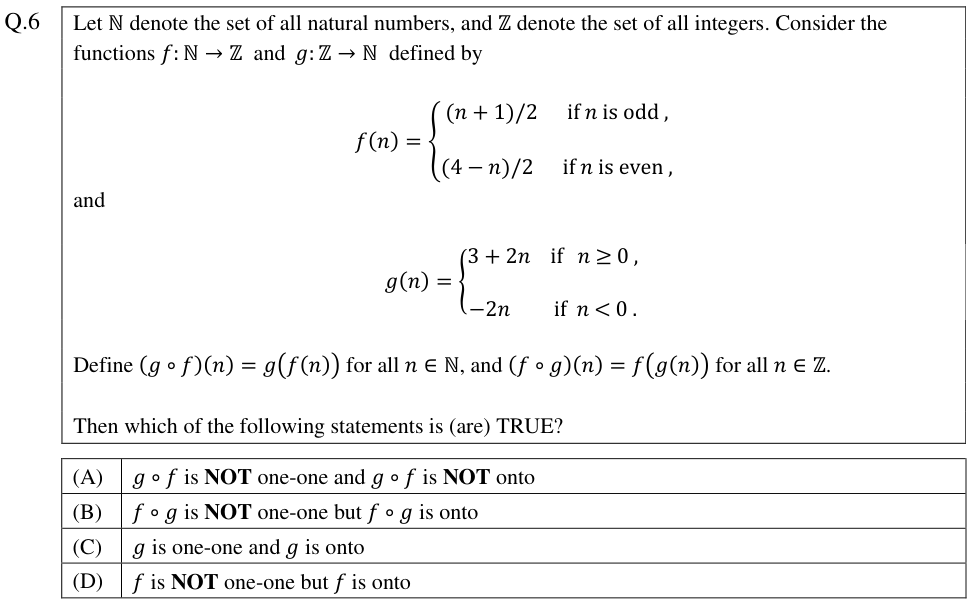

torch.Size([3080, 1176]) torch.float32
To analyze the functions \( f \) and \( g \) and their compositions, let's evaluate each function individually and then the compositions.

### Function Analysis

1. **Function \( f: \mathbb{N} \to \mathbb{Z} \)**:
   - For odd \( n \): \( f(n) = \frac{n+1}{2} \)
   - For even \( n \): \( f(n) = \frac{4-n}{2} \)

   Let's examine the values generated by \( f \):
   - If \( n = 2k+1 \) (odd), then \( f(2k+1) = k + 1 \). Thus, \( f(n) \) can be any non-negative integer.
   - If \( n = 2k \) (even), then \( f(2k) = 2-k \). Hence, \( f(n) \) can take on both positive and negative integers but is limited to specific even numbers within certain ranges.

### Compositions

#### Composition \( g \circ f: \mathbb{N} \to \mathbb{Z} \)
For \( n \in \mathbb{N} \):
\[
(g \circ f)(n) = g(f(n))
\]

Let's consider some specific cases:
- If \( n = 0 \) (or an even number), say \( n = 4 \):
  - \( f(4) = 2 - \frac{4}{2} = 0 \)
  - Then, \( g(0) = 3 \)

- If \( n = 5 

In [ ]:
def perform_sample_inference_manual(model, tokenizer):
    from transformers import TextStreamer
    from IPython.display import display  # for showing images in Jupyter
    from PIL import Image

    # Enable inference mode (only for Unsloth)
    FastVisionModel.for_inference(model)  # Uncomment when using unsloth

    image_path = r"C:\Multilingual Dataset\final_dataset\images\2025\P1\English\Mathematics\2025_P1_English_Mathematics_MCQ-Multiple_q2_MCQ-Multiple_page4.png"
    image = Image.open(image_path)
    instruction_text = '''Solve this multi-correct math question. Come up with a detailed analysis and mark your answer in latex as \\boxed{final_answer} (e.g., \\boxed{AB} or \\boxed{ABC})'''

    # 👀 Display the image
    display(image)

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction_text}
        ]}
    ]

    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    print(inputs["pixel_values"].shape, inputs["pixel_values"].dtype)
    _ = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=1280,
        use_cache=True,
        temperature=1.5,
        min_p=0.1
    )

perform_sample_inference_manual(model, tokenizer)

## Evaluating on VMCBench_DEV

Let's get updated numbers on VMCBench_DEV now that our model has been SFTed.

In [ ]:
import re
from datasets import load_dataset
from PIL import Image
import io
import base64
from typing import Optional, Dict, Any, List
import numpy as np
import torch
from collections import defaultdict

def extract_latex_answer(text: str) -> Optional[str]:
    """Extract answer from \\boxed{} latex format"""
    pattern = r'\\boxed\{([^}]*)\}'
    matches = re.findall(pattern, text)
    if matches:
        # Return the last match and clean it
        answer = matches[-1].strip()
        # Extract just the letter if it's in the format
        letter_match = re.match(r'^([A-D])', answer, re.IGNORECASE)
        if letter_match:
            return letter_match.group(1).upper()
        return answer.upper()
    return None

def extract_answer_fallback(text: str) -> Optional[str]:
    """Fallback method to extract answer if \\boxed{} format not found"""
    # Look for common patterns like "The answer is A" or just "A" at the end
    patterns = [
        r'(?:answer is|answer:|final answer is|final answer:)\s*([A-D])',
        r'\b([A-D])\s*(?:is correct|is the answer)',
        r'^([A-D])$',  # Just the letter alone
        r'(?:^|\n)([A-D])(?:\.|,|\s|$)'  # Letter at start of line or standalone
    ]

    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE)
        if match:
            return match.group(1).upper()

    # Last resort: check if any single letter A-D appears in the last line
    lines = text.strip().split('\n')
    if lines:
        last_line = lines[-1].strip()
        for letter in ['A', 'B', 'C', 'D']:
            if letter in last_line.upper():
                return letter

    return None

def format_vmcbench_question(question: str, A: str, B: str, C: str, D: str) -> str:
    """Format VMC-Bench question with options"""
    formatted = f"{question}\nA. {A}\nB. {B}\nC. {C}\nD. {D}\n\nProvide your answer in the format \\boxed{{answer}} (e.g., \\boxed{{A}} or \\boxed{{B}})."
    return formatted

def run_inference_vmcbench(model, tokenizer, image, question_text: str) -> str:
    """Run inference on a VMC-Bench sample"""
    # Enable inference mode
    FastVisionModel.for_inference(model)

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": question_text}
        ]}
    ]

    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=1280,
            use_cache=True,
            temperature=0.1,  # Lower temperature for more deterministic answers
            min_p=0.1,
            do_sample=True
        )

    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the generated part (after the input)
    input_length = len(tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True))
    generated_text = response[input_length:].strip()

    return generated_text

def compare_vmcbench_answers(predicted: str, ground_truth: str) -> bool:
    """Compare predicted answer with ground truth for VMC-Bench"""
    if not predicted:
        return False

    # Both should be single letters A, B, C, or D
    predicted = predicted.strip().upper()
    ground_truth = ground_truth.strip().upper()

    return predicted == ground_truth

def evaluate_vmcbench_dev(model, tokenizer, max_samples: Optional[int] = None,
                          verbose: bool = True) -> Dict[str, Any]:
    """
    Evaluate model on VMC-Bench dev split

    Args:
        model: The vision-language model
        tokenizer: The tokenizer
        max_samples: Maximum number of samples to evaluate (None for all)
        verbose: Whether to print detailed results

    Returns:
        Dictionary with evaluation results
    """

    # Load the dataset
    print("Loading VMC-Bench dev split...")
    dataset = load_dataset("suyc21/VMCBench", split="dev")

    if max_samples:
        dataset = dataset.select(range(min(max_samples, len(dataset))))

    print(f"Evaluating on {len(dataset)} samples...")

    correct = 0
    total = 0
    results = []

    # Track performance by category
    category_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

    for i, sample in enumerate(dataset):
        try:
            # Extract sample data
            index = sample.get('index', i)
            question = sample['question']
            option_A = sample['A']
            option_B = sample['B']
            option_C = sample['C']
            option_D = sample['D']
            ground_truth = sample['answer']  # Should be A, B, C, or D
            category = sample.get('category', 'unknown')
            image = sample['image']  # PIL Image

            # Convert image if needed
            if isinstance(image, str):
                # If image is base64 encoded
                image_data = base64.b64decode(image)
                image = Image.open(io.BytesIO(image_data))
            elif not isinstance(image, Image.Image):
                # Convert to PIL Image if not already
                image = Image.fromarray(np.array(image))

            # Format the question with options
            formatted_question = format_vmcbench_question(question, option_A, option_B, option_C, option_D)

            # Run inference
            generated_text = run_inference_vmcbench(model, tokenizer, image, formatted_question)

            # Extract answer from latex format
            predicted_answer = extract_latex_answer(generated_text)

            # If extraction failed, try fallback methods
            if not predicted_answer or predicted_answer not in ['A', 'B', 'C', 'D']:
                predicted_answer = extract_answer_fallback(generated_text)

            # Ensure we have a valid answer
            if not predicted_answer:
                predicted_answer = "INVALID"

            # Compare with ground truth
            is_correct = compare_vmcbench_answers(predicted_answer, ground_truth)

            if is_correct:
                correct += 1
                category_stats[category]['correct'] += 1

            total += 1
            category_stats[category]['total'] += 1

            # Store result
            result = {
                'index': index,
                'question': question,
                'options': {
                    'A': option_A,
                    'B': option_B,
                    'C': option_C,
                    'D': option_D
                },
                'category': category,
                'ground_truth': ground_truth,
                'predicted': predicted_answer,
                'generated_text': generated_text,
                'correct': is_correct
            }
            results.append(result)

            if verbose and (i + 1) % 10 == 0:
                current_acc = correct / total
                print(f"Progress: {i + 1}/{len(dataset)}, Accuracy so far: {current_acc:.3f}")

            if verbose and i < 5:  # Show first few examples
                print(f"\n--- Example {i + 1} ---")
                print(f"Category: {category}")
                print(f"Question: {question}")
                print(f"A. {option_A}")
                print(f"B. {option_B}")
                print(f"C. {option_C}")
                print(f"D. {option_D}")
                print(f"Ground Truth: {ground_truth}")
                print(f"Predicted: {predicted_answer}")
                print(f"Correct: {is_correct}")
                print(f"Generated (first 200 chars): {generated_text[:200]}..." if len(generated_text) > 200 else f"Generated: {generated_text}")

        except Exception as e:
            print(f"Error processing sample {i} (index {sample.get('index', i)}): {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    # Calculate final metrics
    accuracy = correct / total if total > 0 else 0

    # Calculate accuracy by category
    category_accuracy = {}
    for cat, stats in category_stats.items():
        if stats['total'] > 0:
            category_accuracy[cat] = {
                'accuracy': stats['correct'] / stats['total'],
                'correct': stats['correct'],
                'total': stats['total']
            }

    # Count invalid predictions
    invalid_predictions = sum(1 for r in results if r['predicted'] == "INVALID")

    evaluation_results = {
        'overall_accuracy': accuracy,
        'total_samples': total,
        'correct_samples': correct,
        'invalid_predictions': invalid_predictions,
        'accuracy_by_category': category_accuracy,
        'detailed_results': results
    }

    # Print summary
    print(f"\n{'='*60}")
    print(f"VMC-BENCH DEV SPLIT EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.3f} ({correct}/{total})")
    print(f"Invalid Predictions: {invalid_predictions}/{total} ({invalid_predictions/total*100:.1f}%)")

    if category_accuracy:
        print(f"\nAccuracy by Category:")
        # Sort by category name for consistent display
        for cat in sorted(category_accuracy.keys()):
            stats = category_accuracy[cat]
            print(f"  {cat}: {stats['accuracy']:.3f} ({stats['correct']}/{stats['total']})")

    # Show some incorrect predictions for debugging
    incorrect_results = [r for r in results if not r['correct']]
    if incorrect_results and verbose:
        print(f"\nSample Incorrect Predictions (first 3):")
        for i, r in enumerate(incorrect_results[:3]):
            print(f"\n  {i+1}. Category: {r['category']}")
            print(f"     Question: {r['question'][:100]}...")
            print(f"     Ground Truth: {r['ground_truth']}")
            print(f"     Predicted: {r['predicted']}")
            print(f"     Generated: {r['generated_text'][:150]}...")

    return evaluation_results

# # Run evaluation on first 50 samples
# results = evaluate_vmcbench_dev(model, tokenizer, max_samples=1000, verbose=True)

# Run full evaluation
results = evaluate_vmcbench_dev(model, tokenizer, verbose=True)

# Save detailed results if needed
# import json
# with open('vmcbench_dev_results.json', 'w') as f:
#     json.dump(results, f, indent=2, default=str)

# print(f"\nResults saved to vmcbench_dev_results.json")

Loading VMC-Bench dev split...


README.md: 0.00B [00:00, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/520M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8018 [00:00<?, ? examples/s]

Evaluating on 1000 samples...

--- Example 1 ---
Category: MMMU
Question: Write the signal f(t) shown in <image 1> using the step functions.
A. 5t^2 [u(t) - u(t - 2)] + 20[u(t - 2) - u(t - 5)] + 15(t - 7)[u(t - 5) - u(t - 7)]
B. 5t^2 [u(t) - u(t - 2)] + 15[u(t - 2) - u(t - 5)] + 15(t - 7)[u(t - 5) - u(t - 7)]
C. 5t^2 [u(t) - u(t - 2)] + 20[u(t - 2) - u(t - 5)] + 10(t - 7)[u(t - 5) - u(t - 7)]
D. 5t [u(t) - u(t - 2)] + 20[u(t - 2) - u(t - 5)] + 15(t - 7)[u(t - 5) - u(t - 7)]
Ground Truth: A
Predicted: B
Correct: False
Generated (first 200 chars): Here is a step-by-step reasoning chain to determine the correct expression for the signal f(t) from the graph:

1. **Understand the Graph:**
   The graph shows the function `f(t)` over the time interv...

--- Example 2 ---
Category: MMMU
Question: <image 1> deals with the study of political conduct within a ____ frame of reference.
A. Cultural
B. Economic
C. Sociological
D. Psychological
Ground Truth: C
Predicted: C
Correct: True
Generated (fir

## Evaluating on MathVista - testmini

Let's test MathVista next.

In [ ]:
import re
import math
from datasets import load_dataset
from transformers import TextStreamer
from PIL import Image
import io
import base64
from typing import Optional, Union, List, Dict, Any
import numpy as np

def extract_latex_answer(text: str) -> Optional[str]:
    """Extract answer from \\boxed{} latex format"""
    pattern = r'\\boxed\{([^}]*)\}'
    matches = re.findall(pattern, text)
    if matches:
        return matches[-1].strip()  # Return the last match
    return None

def extract_numeric_value(answer_str: str) -> Optional[float]:
    """Extract numeric value from answer string, handling various formats"""
    if not answer_str:
        return None

    # Remove common units and extra text
    cleaned = re.sub(r'[^\d\.-]', '', answer_str)

    # Try to extract a number
    number_pattern = r'-?\d*\.?\d+'
    match = re.search(number_pattern, cleaned)
    if match:
        try:
            return float(match.group())
        except ValueError:
            pass

    return None

def format_choices(choices: List[str]) -> str:
    """Format multiple choice options for the prompt"""
    if not choices:
        return ""

    formatted = "\nChoices:\n"
    for i, choice in enumerate(choices):
        formatted += f"({chr(65 + i)}) {choice}\n"
    return formatted

def round_to_precision(value: float, precision: Optional[int]) -> float:
    """Round value to specified precision"""
    if precision is None:
        return value
    return round(value, precision)

def compare_answers(predicted: str, ground_truth: str, choices: List[str],
                   precision: Optional[int], unit: Optional[str]) -> bool:
    """Compare predicted answer with ground truth, handling various cases"""

    # If multiple choice, do exact string matching (case-insensitive)
    if choices:
        # Try direct comparison first
        if predicted.strip().lower() == ground_truth.strip().lower():
            return True

        # Try matching against choice options
        for i, choice in enumerate(choices):
            choice_letter = chr(65 + i)  # A, B, C, D...
            if (predicted.strip().lower() == choice_letter.lower() or
                predicted.strip().lower() == choice.strip().lower()):
                return ground_truth.strip().lower() == choice.strip().lower()
        return False

    # For numeric answers, extract and compare numbers
    pred_num = extract_numeric_value(predicted)
    gt_num = extract_numeric_value(ground_truth)

    if pred_num is not None and gt_num is not None:
        # Apply precision rounding to both
        if precision is not None:
            pred_num = round_to_precision(pred_num, precision)
            gt_num = round_to_precision(gt_num, precision)

        # Use small tolerance for floating point comparison
        tolerance = 10 ** (-precision if precision else -6)
        return abs(pred_num - gt_num) < tolerance

    # Fallback to string comparison
    return predicted.strip().lower() == ground_truth.strip().lower()

def run_inference_on_sample(model, tokenizer, image, question: str, choices: List[str]) -> str:
    """Run inference on a single sample"""
    # Format the prompt
    prompt = question
    if choices:
        prompt += format_choices(choices)
    prompt += "\n\nProvide your answer in the format \\boxed{answer}."

    # Enable inference mode
    FastVisionModel.for_inference(model)

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": prompt}
        ]}
    ]

    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=1280,
            use_cache=True,
            temperature=0.1,  # Lower temperature for more consistent answers
            min_p=0.1,
            do_sample=True
        )

    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the generated part (after the input)
    input_length = len(tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True))
    generated_text = response[input_length:].strip()

    return generated_text

def evaluate_mathvista_testmini(model, tokenizer, max_samples: Optional[int] = None,
                               verbose: bool = True) -> Dict[str, Any]:
    """
    Evaluate model on MathVista testmini subset

    Args:
        model: The vision-language model
        tokenizer: The tokenizer
        max_samples: Maximum number of samples to evaluate (None for all)
        verbose: Whether to print detailed results

    Returns:
        Dictionary with evaluation results
    """

    # Load the dataset
    print("Loading MathVista testmini dataset...")
    dataset = load_dataset("AI4Math/MathVista", split="testmini")

    if max_samples:
        dataset = dataset.select(range(min(max_samples, len(dataset))))

    print(f"Evaluating on {len(dataset)} samples...")

    correct = 0
    total = 0
    results = []

    for i, sample in enumerate(dataset):
        try:
            # Extract sample data
            pid = sample['pid']
            question = sample['question']
            image = sample['decoded_image']  # This should be a PIL Image
            choices = sample.get('choices', []) if sample.get('choices') else []
            unit = sample.get('unit')
            precision = sample.get('precision')
            ground_truth = sample['answer']
            question_type = sample.get('question_type', '')
            answer_type = sample.get('answer_type', '')

            # Convert image if needed
            if isinstance(image, str):
                # If image is base64 encoded
                image_data = base64.b64decode(image)
                image = Image.open(io.BytesIO(image_data))
            elif not isinstance(image, Image.Image):
                # Convert to PIL Image if not already
                image = Image.fromarray(np.array(image))

            # Run inference
            generated_text = run_inference_on_sample(model, tokenizer, image, question, choices)

            # Extract answer from latex format
            predicted_answer = extract_latex_answer(generated_text)
            if not predicted_answer:
                # Fallback: try to extract last line or any numeric value
                lines = generated_text.strip().split('\n')
                predicted_answer = lines[-1].strip() if lines else ""

            # Compare with ground truth
            is_correct = compare_answers(predicted_answer, ground_truth, choices, precision, unit)

            if is_correct:
                correct += 1
            total += 1

            # Store result
            result = {
                'pid': pid,
                'question_type': question_type,
                'answer_type': answer_type,
                'question': question,
                'ground_truth': ground_truth,
                'predicted': predicted_answer,
                'generated_text': generated_text,
                'correct': is_correct,
                'has_choices': bool(choices),
                'unit': unit,
                'precision': precision
            }
            results.append(result)

            if verbose and (i + 1) % 10 == 0:
                current_acc = correct / total
                print(f"Progress: {i + 1}/{len(dataset)}, Accuracy so far: {current_acc:.3f}")

            if verbose and i < 5:  # Show first few examples
                print(f"\n--- Example {i + 1} ---")
                print(f"Question: {question}")
                if choices:
                    print(f"Choices: {choices}")
                print(f"Ground Truth: {ground_truth}")
                print(f"Predicted: {predicted_answer}")
                print(f"Correct: {is_correct}")
                print(f"Generated: {generated_text[:200]}..." if len(generated_text) > 200 else generated_text)

        except Exception as e:
            print(f"Error processing sample {i}: {str(e)}")
            continue

    # Calculate final metrics
    accuracy = correct / total if total > 0 else 0

    # Calculate accuracy by question type
    type_accuracy = {}
    for qtype in set(r['question_type'] for r in results if r['question_type']):
        type_results = [r for r in results if r['question_type'] == qtype]
        type_correct = sum(1 for r in type_results if r['correct'])
        type_accuracy[qtype] = type_correct / len(type_results) if type_results else 0

    # Calculate accuracy by answer type
    answer_type_accuracy = {}
    for atype in set(r['answer_type'] for r in results if r['answer_type']):
        atype_results = [r for r in results if r['answer_type'] == atype]
        atype_correct = sum(1 for r in atype_results if r['correct'])
        answer_type_accuracy[atype] = atype_correct / len(atype_results) if atype_results else 0

    # Multiple choice vs open-ended
    mc_results = [r for r in results if r['has_choices']]
    open_results = [r for r in results if not r['has_choices']]

    mc_accuracy = sum(1 for r in mc_results if r['correct']) / len(mc_results) if mc_results else 0
    open_accuracy = sum(1 for r in open_results if r['correct']) / len(open_results) if open_results else 0

    evaluation_results = {
        'overall_accuracy': accuracy,
        'total_samples': total,
        'correct_samples': correct,
        'accuracy_by_question_type': type_accuracy,
        'accuracy_by_answer_type': answer_type_accuracy,
        'multiple_choice_accuracy': mc_accuracy,
        'open_ended_accuracy': open_accuracy,
        'detailed_results': results
    }

    # Print summary
    print(f"\n{'='*50}")
    print(f"MATHVISTA TESTMINI EVALUATION RESULTS")
    print(f"{'='*50}")
    print(f"Overall Accuracy: {accuracy:.3f} ({correct}/{total})")
    print(f"Multiple Choice Accuracy: {mc_accuracy:.3f} ({len(mc_results)} samples)")
    print(f"Open-ended Accuracy: {open_accuracy:.3f} ({len(open_results)} samples)")

    if type_accuracy:
        print(f"\nAccuracy by Question Type:")
        for qtype, acc in sorted(type_accuracy.items()):
            print(f"  {qtype}: {acc:.3f}")

    if answer_type_accuracy:
        print(f"\nAccuracy by Answer Type:")
        for atype, acc in sorted(answer_type_accuracy.items()):
            print(f"  {atype}: {acc:.3f}")

    return evaluation_results

# Run evaluation on first 50 samples
results = evaluate_mathvista_testmini(model, tokenizer, max_samples=1000, verbose=True)

# Save detailed results if needed
# import json
# with open('mathvista_results.json', 'w') as f:
#     json.dump(results, f, indent=2, default=str)

Loading MathVista testmini dataset...
Evaluating on 1000 samples...
Error processing sample 0: 'float' object cannot be interpreted as an integer

--- Example 2 ---
Question: what is the total volume of the measuring cup?
Ground Truth: 1000
Predicted: 1000
Correct: True
The image shows a measuring cup with markings for liters and milliliters. The maximum volume marked on the measuring cup is 1000 milliliters (ml), which is equivalent to 1 liter (L).

\boxed{1000}

--- Example 3 ---
Question: △ABC的两内角平分线OB、OC相交于点O，若∠A＝110°，则∠BOC＝（）
Choices: ['135°', '140°', '145°', '150°']
Ground Truth: 145°
Predicted: 145^\circ
Correct: False
Generated: To solve this problem, we need to use the properties of the angles in a triangle and the angle bisectors.

Given:
- ∠A = 110°
- OB and OC are the angle bisectors of ∠ABC and ∠ACB respectively, meeting...

--- Example 4 ---
Question: Subtract all large rubber spheres. Subtract all big shiny cylinders. How many objects are left?
Ground Truth: 4
Predicted: